# 1. Packages needed

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from skimage.io import imread
from skimage.color import rgb2gray
from skimage import measure, morphology, filters
from pandas import DataFrame
import re
from skimage.filters import try_all_threshold

# 2. Specifing Input and Output directories

In [2]:
# Define input and output directories
input_dir = "./tiff_images"  # Directory containing TIFF images
output_dir = "./results"  # Directory to save CSV files
os.makedirs(output_dir, exist_ok=True)

# 3. Describing functions
## The filter may need to be adjusted depending on the collection of files. threshold_minimum() or threshold_otsu() tends to work the best. An area filter may also be adjusted to filter out noise. 

In [3]:
# Function to extract condition name from filename
def extract_condition(filename):
    match = re.match(r"([\w]+_)", filename)  # Extracts first part before second underscore
    return match.group(1) if match else "unknown"
# Function to process an image
def process_image(image_path):
    im = imread(image_path)
    if len(im.shape) == 3:  # Convert to grayscale if RGB
        im = rgb2gray(im)
    
    threshold = filters.threshold_minimum(im)  ## change to filter that works the best: threshold_[filter](im_gray)
    binary_mask = im > threshold
    
    # Invert mask for processing
    inverted_mask = 1 - binary_mask
    
    # Label connected components
    labels = measure.label(inverted_mask)
    props = measure.regionprops(labels)
    
    # Create a list to store the properties of each labeled region
    lr = []
    for prop in props:
        aa = [prop.label, prop.area, prop.centroid, prop.major_axis_length, prop.minor_axis_length]
        lr.append(aa)
    
    # Create DataFrame and filter out small objects based on area
    Outprops = DataFrame(lr, columns=['Original_Label', 'Area', 'Centroid', 'Length', 'Width'])
    df3 = Outprops[Outprops['Area'] > 60]  # Filter out objects with area <= 60
    
    # Add a new column with sequential labels starting from 1
    df3 = df3.reset_index(drop=True)
    df3['Adjusted_Label'] = df3.index + 1
    
    # Create a new binary mask that includes only the filtered regions
    filtered_binary_mask = np.zeros_like(inverted_mask)
    for _, row in df3.iterrows():
        original_label_id = row['Original_Label']
        filtered_binary_mask[labels == original_label_id] = 1
    
    # Plot the filtered binary mask with adjusted labels
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(filtered_binary_mask, cmap='gray')
    ax.set_title("Filtered Objects with Sequential Labels on Binary Mask")
    
    for _, row in df3.iterrows():
        centroid = row['Centroid']
        adjusted_label = row['Adjusted_Label']
        ax.text(centroid[1], centroid[0], str(adjusted_label), color='red', fontsize=12, ha='center', va='center')
    
    plt.axis('off')
    plt.savefig(os.path.join(output_dir, os.path.basename(image_path).replace('.tif', '_filtered.png')), bbox_inches='tight', dpi=300)
    plt.close()
    
    return df3

# 4. Generate a CSV file with labeled objects
## Information such as Original_label, Area, Centroid, Length, Width, and Adjusted_labels are stored. 

In [4]:
# Iterate through all TIFF images
for filename in os.listdir(input_dir):
    if filename.endswith(".tif"):
        condition = extract_condition(filename)  # Extract condition from filename
        image_path = os.path.join(input_dir, filename)
        df_result = process_image(image_path)
        
        # Save CSV file for each condition
        csv_path = os.path.join(output_dir, f"{condition}.csv")
        df_result.to_csv(csv_path, index=False)
        print(f"Saved: {csv_path}")

Saved: ./results\58A_exp_.csv
Saved: ./results\58A_exp_.csv
Saved: ./results\58A_exp_.csv
Saved: ./results\58A_exp_.csv
Saved: ./results\58A_exp_.csv
Saved: ./results\58A_exp_.csv
Saved: ./results\58A_exp_.csv
Saved: ./results\58A_exp_.csv
Saved: ./results\58A_exp_.csv
Saved: ./results\58A_exp_.csv
Saved: ./results\58A_exp_.csv
Saved: ./results\58A_exp_.csv
Saved: ./results\58A_exp_.csv
Saved: ./results\58A_exp_.csv
Saved: ./results\58A_exp_.csv
Saved: ./results\58A_exp_.csv
Saved: ./results\58A_exp_.csv
Saved: ./results\58A_exp_.csv
Saved: ./results\58A_stat_.csv
Saved: ./results\58A_stat_.csv
Saved: ./results\58A_stat_.csv
Saved: ./results\58A_stat_.csv
Saved: ./results\58A_stat_.csv
Saved: ./results\58A_stat_.csv
Saved: ./results\58A_stat_.csv
Saved: ./results\58A_stat_.csv
Saved: ./results\58A_stat_.csv
Saved: ./results\58A_stat_.csv
Saved: ./results\58A_stat_.csv
Saved: ./results\58A_stat_.csv
Saved: ./results\58B_exp_.csv
Saved: ./results\58B_exp_.csv
Saved: ./results\58B_exp_.cs

# 5. Combining all files and converting to microns definitions
## You may need to change the pixels:microns ratio depending on the lens used

In [5]:
# Conversion factor
PIXELS_PER_MICRON = 6 # Depends on lens used. Our x40 lens is 6 pixels per micron

In [16]:
def process_and_visualize(csv_files):
    all_data = []
    
    for file in csv_files:
        df = pd.read_csv(file)
        df['Length (µm)'] = df['Length'] / PIXELS_PER_MICRON  # Convert pixels to microns
        df['Width (µm)'] = df['Width'] / PIXELS_PER_MICRON  # Convert pixels to microns
        df['Aspect Ratio'] = df['Length (µm)'] / df['Width (µm)']  # Calculate aspect ratio
        df['Area'] = df['Area'] / PIXELS_PER_MICRON **2
        df['Condition'] = file.split("_")[-3] + "_" + file.split("_")[-2] # Use filename as condition, may need to change depending on file naming scheme
        all_data.append(df)
    
    combined_df = pd.concat(all_data, ignore_index=True)
    
    # Set style
    sns.set_style("whitegrid")
    
    # Plot and save individual histograms
    plot_params = [
        ('Length (µm)', 'Length Distribution', 'length_distribution.png'),
        ('Width (µm)', 'Width Distribution', 'width_distribution.png'),
        ('Aspect Ratio', 'Aspect Ratio Distribution', 'aspect_ratio_distribution.png'),
        ('Area', 'Area Distribution', 'area_distribution.png')
    ]
    
    for x_col, title, filename in plot_params:
        plt.figure(figsize=(8, 5))
        sns.histplot(data=combined_df, x=x_col, hue='Condition', bins=30, kde=True, alpha=0.6)
        plt.title(title)
        plt.tight_layout()
        plt.savefig(filename)
        plt.show()
        
    return combined_df


# 6. Processing and visualizing data

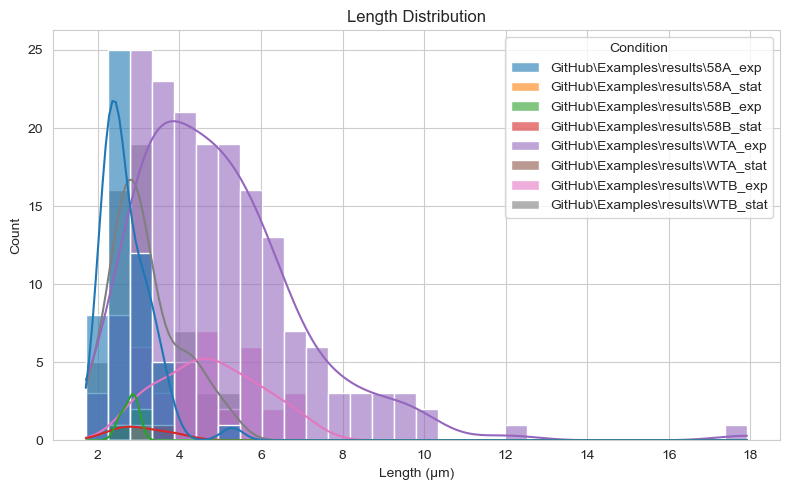

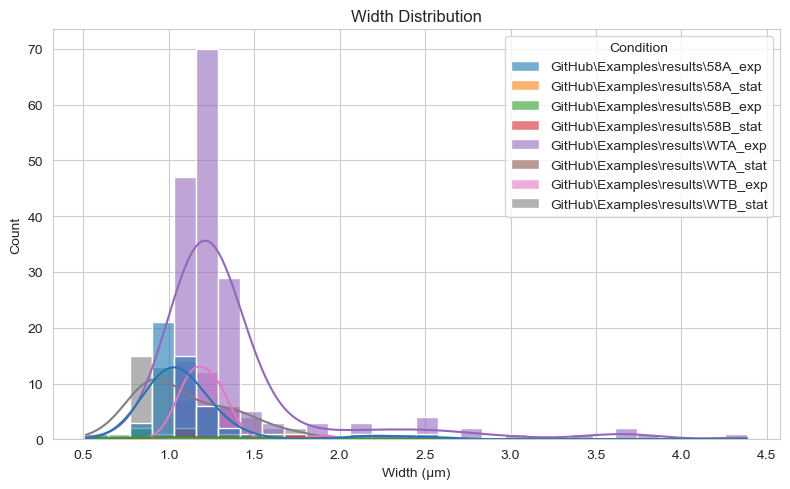

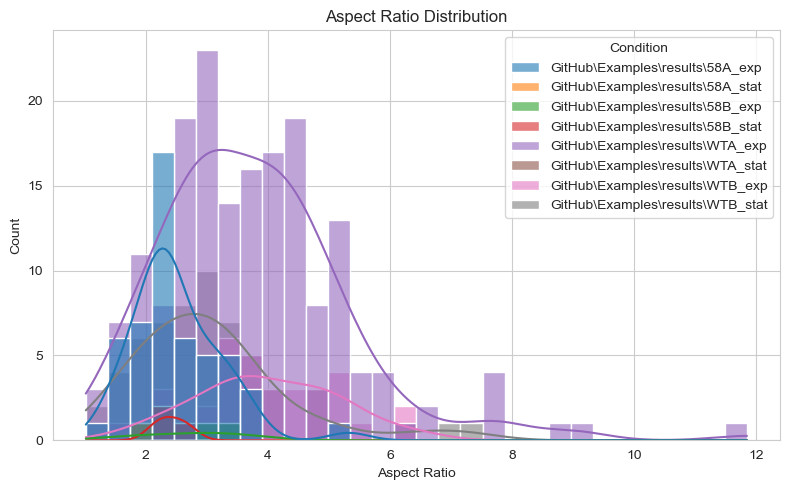

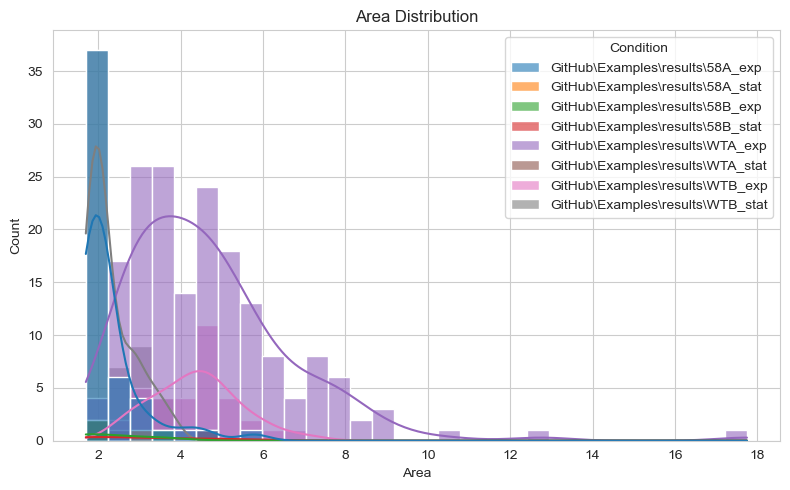

In [18]:
# Update path to .csv files
csv_files = glob.glob(r"C:\Users\strocha\Documents\Python Scripts\Keilen\CellSize_GitHub\Examples\results\*.csv")  # Update with your CSV folder path
combined_data = process_and_visualize(csv_files)

In [9]:
# Save combined data if needed
combined_data.to_csv("combined_data.csv", index=False)